# TGFB2

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


In [ ]:
### TGFB2
We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TGFB2.


In [2]:
gene_symbol = 'TGFB2'
mane_tx_id = 'NM_003238.6'
mane_protein_id = 'NP_003229.1' 

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()

with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')


from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 36 phenopackets
Individuals Processed: 100%|██████████| 36/36 [00:01<00:00, 20.36individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Aortic root aneurysm,HP:0002616,23
High palate,HP:0000218,21
Pes planus,HP:0001763,20
Joint hypermobility,HP:0001382,18
Inguinal hernia,HP:0000023,18
Arachnodactyly,HP:0001166,17
Abnormal sternum morphology,HP:0000766,16
Retrognathia,HP:0000278,14
Striae distensae,HP:0001065,13
Tall stature,HP:0000098,11


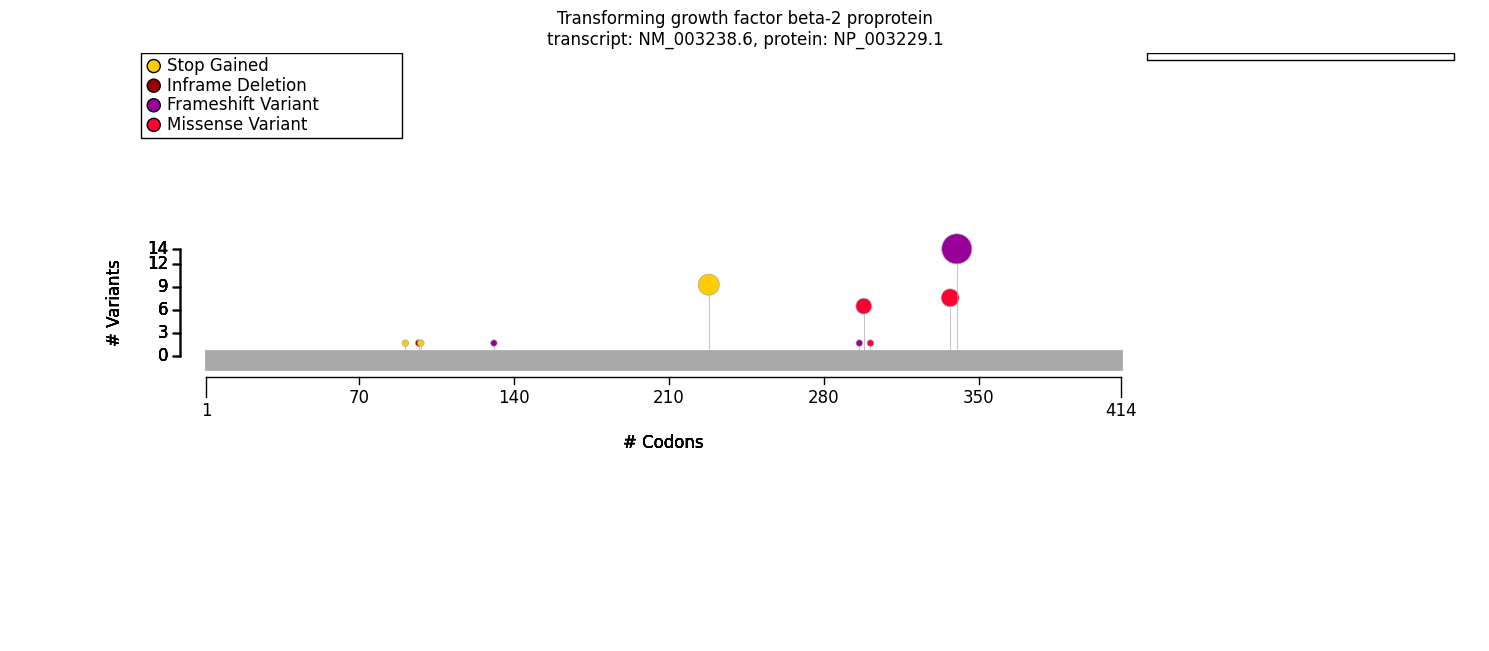

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


tgfb2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tgfb2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense", 
    b_label="other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,16
HMF03,Skipping term because of a child term with the same individual counts,8
HMF08,Skipping general term,53
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,101


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Retrognathia [HP:0000278]                               7/8     88%   7/21   
Inguinal hernia [HP:0000023]                            7/8     88%  11/26   
Mitral valve prolapse [HP:0001634]                      3/4     75%   6/24   
Downslanted palpebral fissures [HP:0000494]             5/8     62%   5/20   
High palate [HP:0000218]                                7/8     88%  14/24   
Aortic dissection [HP:0002647]                          1/8     12%    3/7   
Striae distensae [HP:0001065]                           2/8     25%  11/24   
Pes planus [HP:0001763]                                 6/8     75%  14/23   
Abnormal sternum morphology [HP:0000766]                5/8     62%  12/24   
Arachnodactyly [HP:0001166]                             5/8     62%  12/21   
Long fingers [HP:0100807]                               5/5    100%  12/12   
Abnormal finger morphology [HP:0001167]                 5/5    100%  12/12   
Abnormal appendicular skeleton morphology [HP:0...      5/5    100%  13/13   
Slender finger [HP:0001238]                             5/5    100%  12/12   
Joint hypermobility [HP:0001382]                        5/8     62%  13/23   
Abnormality of joint mobility [HP:0011729]              5/5    100%  13/13   
Hernia of the abdominal wall [HP:0004299]               7/7    100%  11/11   
Hernia [HP:0100790]                                     7/7    100%  11/11   
Abnormal mandible morphology [HP:0000277]               7/7    100%    8/8   
Abnormal facial skeleton morphology [HP:0011821]        7/7    100%    8/8   
Abnormal axial skeleton morphology [HP:0009121]         7/7    100%  20/20   
Aortic root aneurysm [HP:0002616]                       7/8     88%  16/17   
Thoracic aortic aneurysm [HP:0012727]                   7/7    100%  16/16   
Abnormal blood vessel morphology [HP:0033353]           8/8    100%  19/19   
Abnormal aortic morphology [HP:0001679]                 7/7    100%  16/16   
Abnormal systemic arterial morphology [HP:0011004]      7/7    100%  19/19   
Tall stature [HP:0000098]                               4/8     50%   8/14   
Abnormal elasticity of skin [HP:0010647]                4/4    100%  11/11   
Abnormal palate morphology [HP:0000174]                 7/7    100%  16/16   
Abnormal oral cavity morphology [HP:0000163]            7/7    100%  16/16   
Abnormal thorax morphology [HP:0000765]                 5/5    100%  13/13   

Allele group                                                                   \
                                                   Percent Corrected p values   
Retrognathia [HP:0000278]                              33%           0.439980   
Inguinal hernia [HP:0000023]                           42%           0.658830   
Mitral valve prolapse [HP:0001634]                     25%           0.707463   
Downslanted palpebral fissures [HP:0000494]            25%           0.707463   
High palate [HP:0000218]                               58%           1.000000   
Aortic dissection [HP:0002647]                         43%           1.000000   
Striae distensae [HP:0001065]                          46%           1.000000   
Pes planus [HP:0001763]                                61%           1.000000   
Abnormal sternum morphology [HP:0000766]               50%           1.000000   
Arachnodactyly [HP:0001166]                            57%           1.000000   
Long fingers [HP:0100807]                             100%           1.000000   
Abnormal finger morphology [HP:0001167]               100%           1.000000   
Abnormal appendicular skeleton morphology [HP:0...    100%           1.000000   
Slender finger [HP:0001238]                           100%           1.000000   
Joint hypermobility [HP:0001382]                       57%           1.000000   
Abnormality of joint mobility [HP:0011729]      

In [9]:
from gpsea.analysis.predicate.genotype import sex_predicate

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Joint hypermobility [HP:0001382]                      7/8     88%  11/23   
Scoliosis [HP:0002650]                                5/9     56%   6/23   
Striae distensae [HP:0001065]                         2/9     22%  11/23   
Tall stature [HP:0000098]                             1/4     25%  11/18   
Arachnodactyly [HP:0001166]                           6/8     75%  11/21   
High palate [HP:0000218]                              7/9     78%  14/23   
Talipes equinovarus [HP:0001762]                      2/4     50%   3/12   
Downslanted palpebral fissures [HP:0000494]           3/7     43%   7/21   
Long fingers [HP:0100807]                             6/6    100%  11/11   
Abnormal finger morphology [HP:0001167]               6/6    100%  11/11   
Abnormal appendicular skeleton morphology [HP:0...    7/7    100%  11/11   
Slender finger [HP:0001238]                           6/6    100%  11/11   
Abnormality of joint mobility [HP:0011729]            7/7    100%  11/11   
Inguinal hernia [HP:0000023]                          5/9     56%  13/25   
Hernia of the abdominal wall [HP:0004299]             5/5    100%  13/13   
Hernia [HP:0100790]                                   5/5    100%  13/13   
Retrognathia [HP:0000278]                             4/8     50%  10/21   
Abnormal mandible morphology [HP:0000277]             5/5    100%  10/10   
Abnormal facial skeleton morphology [HP:0011821]      5/5    100%  10/10   
Abnormal axial skeleton morphology [HP:0009121]       8/8    100%  19/19   
Aortic root aneurysm [HP:0002616]                     6/6    100%  17/19   
Thoracic aortic aneurysm [HP:0012727]                 6/6    100%  17/17   
Abnormal blood vessel morphology [HP:0033353]         8/8    100%  19/19   
Abnormal aortic morphology [HP:0001679]               6/6    100%  17/17   
Abnormal systemic arterial morphology [HP:0011004]    8/8    100%  18/18   
Abnormal elasticity of skin [HP:0010647]              3/3    100%  12/12   
Abnormal palate morphology [HP:0000174]               8/8    100%  15/15   
Abnormal oral cavity morphology [HP:0000163]          8/8    100%  15/15   
Abnormal sternum morphology [HP:0000766]              4/8     50%  13/24   
Abnormal thorax morphology [HP:0000765]               5/5    100%  13/13   
Pes planus [HP:0001763]                               5/8     62%  15/23   

Sex                                                                            \
                                                   Percent Corrected p values   
Joint hypermobility [HP:0001382]                       48%                1.0   
Scoliosis [HP:0002650]                                 26%                1.0   
Striae distensae [HP:0001065]                          48%                1.0   
Tall stature [HP:0000098]                              61%                1.0   
Arachnodactyly [HP:0001166]                            52%                1.0   
High palate [HP:0000218]                               61%                1.0   
Talipes equinovarus [HP:0001762]                       25%                1.0   
Downslanted palpebral fissures [HP:0000494]            33%                1.0   
Long fingers [HP:0100807]                             100%                1.0   
Abnormal finger morphology [HP:0001167]               100%                1.0   
Abnormal appendicular skeleton morphology [HP:0...    100%                1.0   
Slender finger [HP:0001238]                           100%                1.0   
Abnormality of joint mobility [HP:0011729]            100%                1.0   
Inguinal hernia [HP:0000023]                           52%                1.0   
Hernia of the abdominal wall [HP:0004299]             100%                1.0   
Hernia [HP:0100790]                                   100%                1.0   
Retrognathia [HP:0000278]        

# Summary

In [10]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant association found."

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [11]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,31,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,31,0


In [12]:
summarizer.process_latex(report=report, protein_fig=tgfb2_fig)

Figure saved to ../../supplement/img/TGFB2_protein_diagram-draft.pdf
Output to ../../supplement/tex/TGFB2_summary_draft.tex
